# Particle Filter with Multivariate Normal Resampling

**Jonathan Ramkissoon, Martin Lysy**  
**University of Waterloo** 

---

## Introduction

Parameter inference for stochastic differential equations is challenging due to intractable likelihood functions that integrate over the entire latent space. Particle filters offer a principled solution by providing a consistent estimate of SDE log-likelihood. However, the multinomial resampling step traditionally used in particle filters is not smoothly differentiable with respect to SDE parameters, which can be problematic in many likelihood-based inference methods. In this work we propose a smoothly differentiable particle filter by replacing the resampling step with a multivariate Normal approximation and utilizing the reparameterization trick. This enables a host of gradient based methods for parameter inference. This notebook explains the Multivariate Normal resampling step and it's effect on parameter inference for stochastic differential equations. 


## Stochastic Differential Equations as State-Space Models

Let $\XX(t) = (X_1(t), \ldots, X_d(t))$ denote a $d$-dimensional process satisfying the stochastic differential equation (SDE)

$$
\ud \XX(t) = \dr_{\tth}(\XX(t)) \ud t + \df_{\tth}(\XX(t))^{1/2} \ud \BB(t),
$$

where $\dr_{\tth}(\XX)$ is a $d$-dimensional drift function and $\df_{\tth}(\XX)$ is a $d \times d$ positive-definite diffusion matrix.  We assume that $\XX(t)$ is measured with error at times $t_n = n \dt$ such that the observed data is $\YY_{0:N} = (\YY_0, \ldots, \YY_N)$ with

$$
\YY_n \ind g(\YY_n \mid \XX_n, \tth),
$$

where $\XX_n = \XX(t_n)$.  

Assume that the initial value of the SDE at time $t_0 = 0$ has the prior distribution $\XX_0 \sim \pi(\XX_0 \mid \tth)$. Then the likelihood function is given by

$$
\mathcal L(\tth \mid \YY_{0:N}) = \int \left[\pi(\XX_0 \mid \tth) \cdot \prod_{n=0}^N g(\YY_n \mid \XX_n, \tth) \cdot \prod_{n=1}^N p(\XX_n \mid \XX_{n-1}, \tth)\right] \ud \XX_{0:N}.
$$

However, this expression requires the SDE transition density $p(\XX_n \mid \XX_{n-1}, \tth)$, which is rarely available in closed form.  Instead, the likelihood function is approximated by the so-called Euler (or Euler-Maruyama) discretization method.  Namely, for $m \ge 1$ let $\XX\up m_n$ denote the value of the SDE at time $t = n \dt/m$, such that $\XX\up m_{mn} = \XX_n = \XX(t_n)$.  As $\dt_m = \dt/m \to 0$, the normal approximation

$$
\begin{aligned}
\XX\up m_n & \sim \N( \XX\up m_{n-1} + \dr_{\tth}(\XX\up m_{n-1}) \dt_m, \df_{\tth}(\XX\up m_{n-1}) \dt_m) \\
\iff \XX\up m_n & \sim \varphi(\XX\up m_n \mid \XX\up m_{n-1}, \tth)
\end{aligned}
$$

becomes increasingly accurate.  Thus the Euler approximation of order $m$ (or resolution $m$) to the likelihood function is

$$
\Lhat_m(\tth \mid \YY_{0:N}) = \int \left[\pi(\XX\up m_0 \mid \tth) \cdot \prod_{n=0}^N g(\YY_n \mid \XX\up m_{nm}, \tth) \cdot \prod_{n=1}^{Nm} \varphi(\XX\up m_n \mid \XX\up m_{n-1}, \tth)\right] \ud \XX\up m_{0:Nm},
$$

and we have $\Lhat_m(\tth \mid \YY_{0:N}) \to \mathcal L(\tth \mid \YY_{0:N})$ as $m \to \infty$.

## Log-Likelihood Estimation with Particle Filters

In general, a particle filter is initialized with a point cloud simulated from $\XX^* \sim p(X_0)$. At each timestep it is updated according to the transition density $p(X_t \mid X_{t-1}, \theta)$ and re-weighted according to $p(y_t \mid \XX^*_t, \theta)$. The resulting point cloud after this scheme are samples from the density $p(\XX_{t+1} \mid y_{t+1}, \theta)$. 

Bootstrap particle filters perform a Multinomial resampling step after re-weighting to avoid sample impoverishment. After running this scheme for every timestep, we can sum the log-weights to get an estimate of the log-likelihood. 

In the context of gradient based inference methods, such as maximum likelihood, the multinomial resampling results in non-smooth estimates of the log-likelihood. To ensure a smooth estimate of the log-likelihood, the multinomial resampling step can be replaced with a Multivariate Normal distribution. 

Here, we approximate the particle distribution, **$p(X_{t+1} \mid y_t, X_t)$** with a multivariate Normal. That is, at timestep $t+1$, we have:

- $N$ particles from timestep $t$: $\XX^*_t$
- Corresponding weights from evaluating $p(y_t \mid \XX^*_t)$

Then the particle distribution for timestep $t+1$ uses the weighted mean and weigthed covariance matrix of particles at timestep $t$ as parameters for the MVN.


## MVN Resampling for the Layman

Each timestep, $t$, in the particle filter starts by proposing points for the "location" of the latent variable, $X_t$. Regardless of how these points are proposed, the particle filter will continue by stepping each of the proposed points forward with the transition density (`model.state_sample`) then evaluating the measurement model (`meas_lpdf`) to get the log-weights. Traditionally, the particle filter is initialized with `n_particles` points, and the proposal at each timestep comes from multinomial resampling of these points. A key drawback of this in the context of a differentiable particle filter is that this sampling operation is not differentiable. The MVN resampling replaces this multinomial sampling step with a MVN distribution, which is smoothly differentiable. 


## MVN Approximation in `pfjax`

`pfjax` is set up to accomodate for different resampling methods, and the MVN approximation is no exception. An example of this is shown below: 

# Lotka-Volterra Example

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
import optax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

In [21]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/2), theta + (theta/2))))

dt = 0.1
n_res = 1 
n_obs = 100

key = random.PRNGKey(0)
key, subkey = random.split(key)

In [23]:
# lotvol_model = pf.LotVolModel(dt, n_res) 
lotvol_model = pf.LotVolModelLog(dt, n_res) 
theta = jnp.log(theta)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

# y_meas, x_state = pf.simulate(model = lotvol_model, 
#                               n_obs = n_obs, 
#                               x_init = x_init, 
#                               theta = theta, 
#                               key = subkey)

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = subkey)

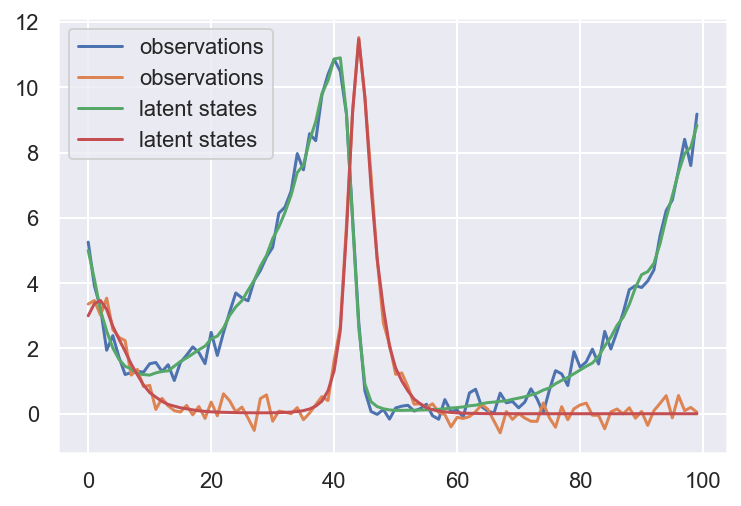

In [4]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

## Log-Likelihood Projection Plots

Below are estimates of the log-likelihood using multinomial resampling and MVN resampling. The MVN resampling proceedure is much smoother than the multinomial resampling estimate. 

In [5]:
# log-likelihood for Lotvol model with MVN resamplings
@jax.jit
def lotvol_pf_mvn_loglik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, 
                           y_meas=y_meas, 
                           n_particles=n_particles, key=key,
                           particle_sampler = pf.particle_resample_mvn)
    return pf.particle_loglik(temp['logw'])

# log-likelihood for Lotvol model with Multinomial resampling
@jax.jit
def lotvol_pf_loglik(theta):
    temp = pf.particle_filter(theta=theta, 
                           model=lotvol_model, y_meas=y_meas,
                           n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])

In [19]:
theta_lims = jnp.log(jnp.array([
    [0.5  , 1.5  ],
    [0.5  , 1.5  ],
    [2.   , 6.   ],
    [0.5  , 1.5  ],
    [0.01 , 0.5 ],
    [0.01 , 0.5 ],
    [0.15, 0.5],
    [0.15, 0.5]]))

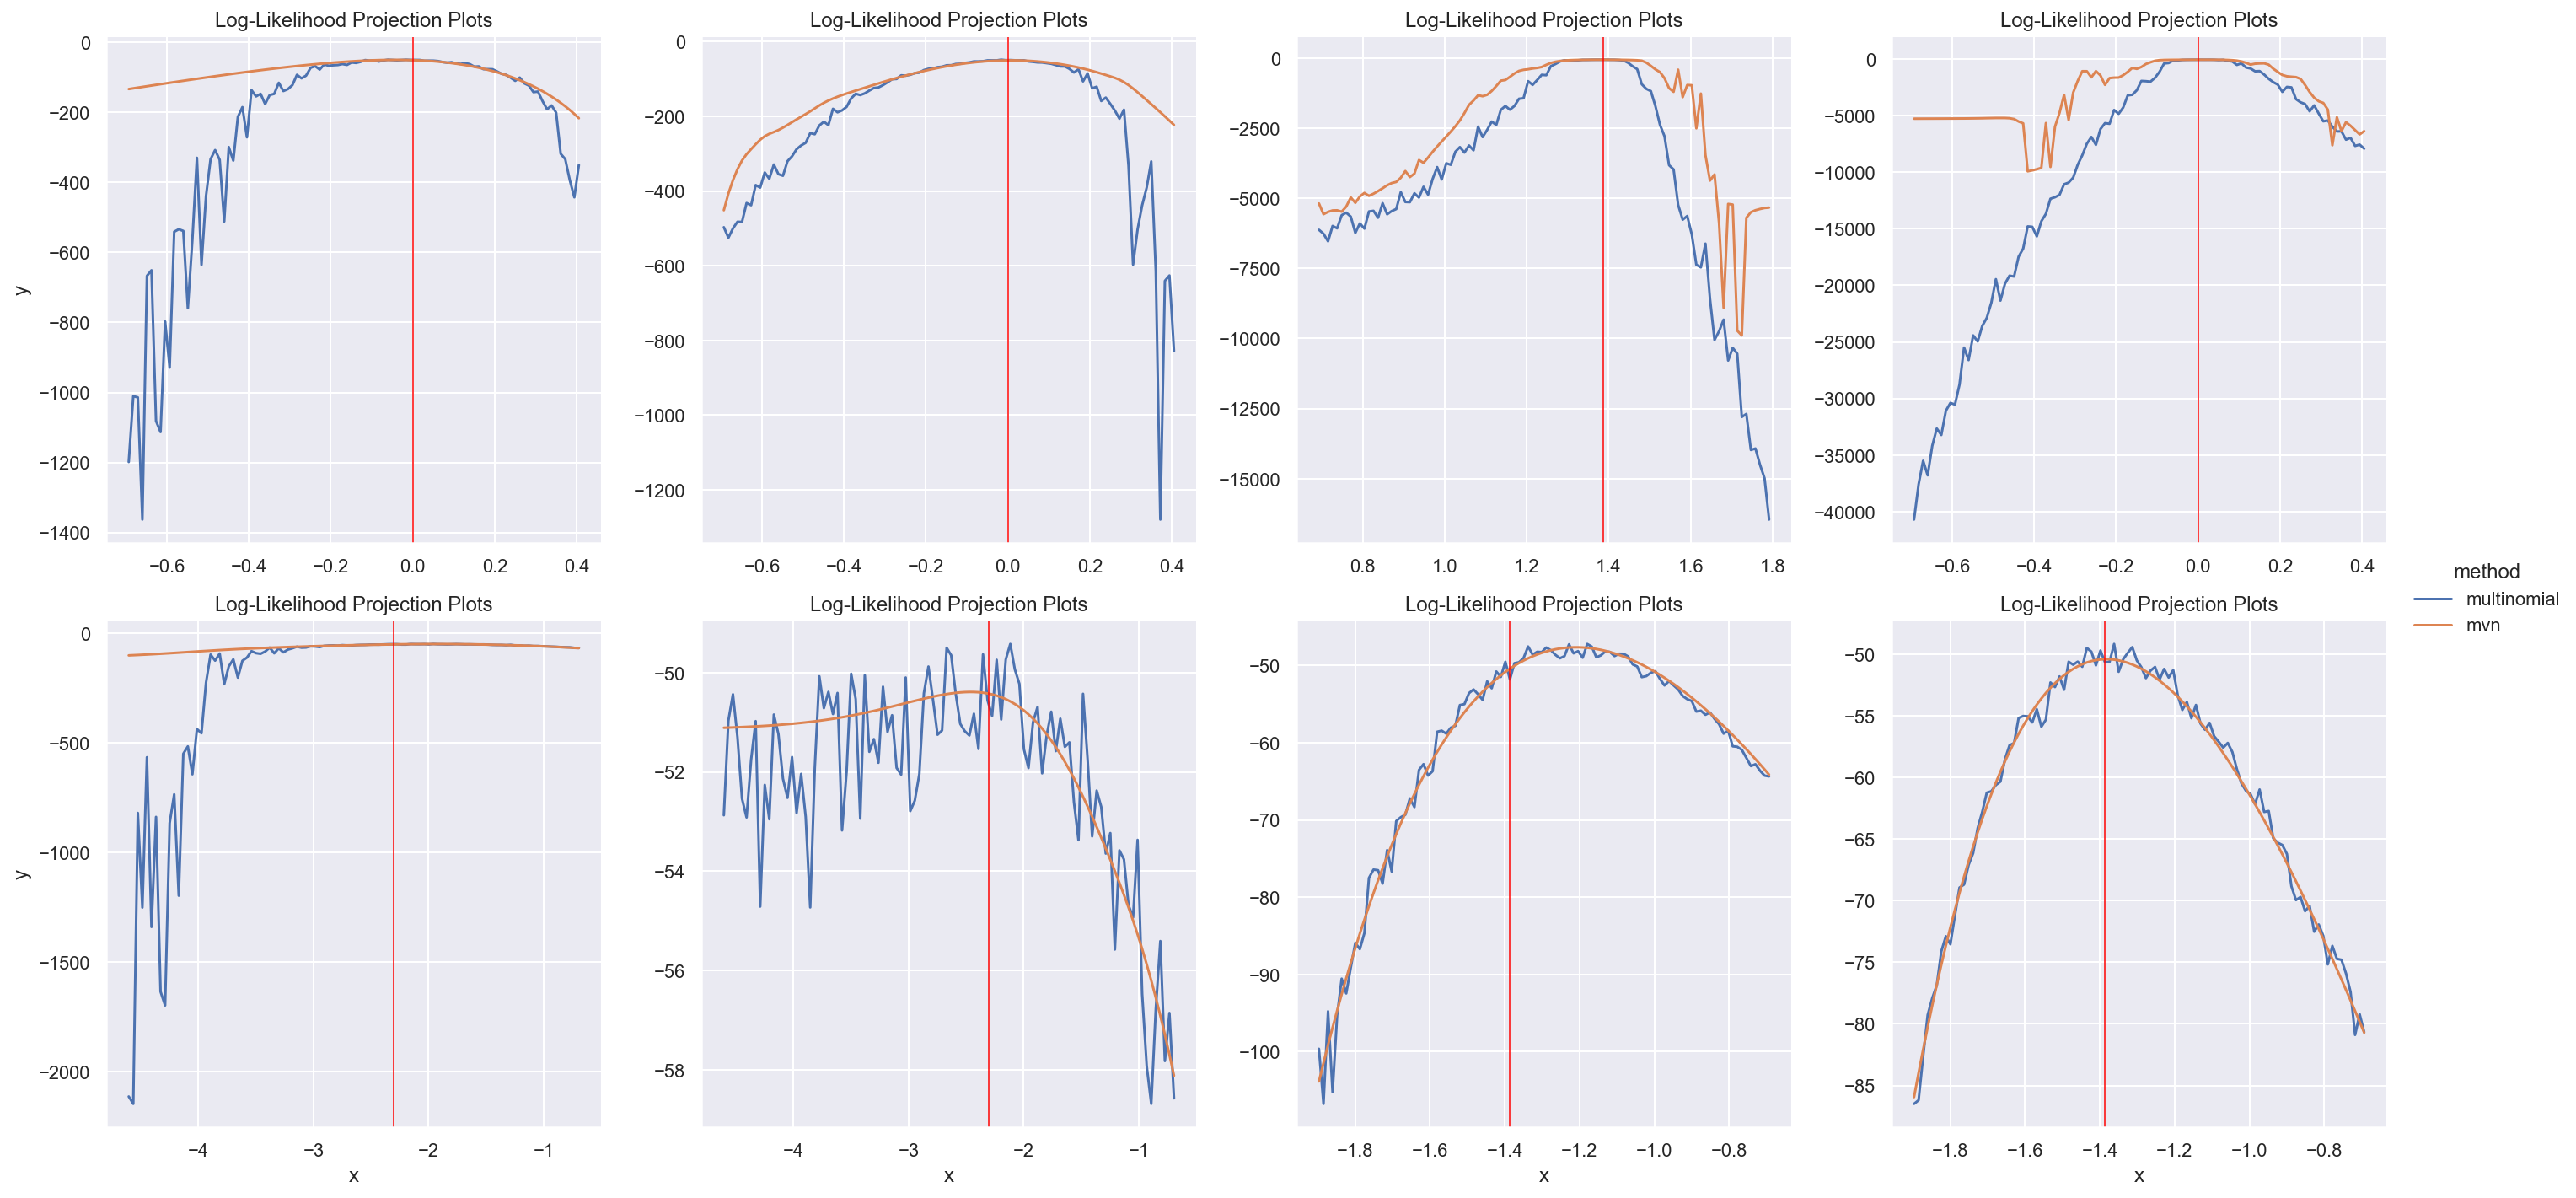

In [20]:
n_particles = 500

plot_mvn = pf.proj_data(fun = lambda x: lotvol_pf_mvn_loglik(x), 
                        theta = theta, theta_lims = theta_lims, 
                        theta_names = theta_names)

plot_multinom = pf.proj_data(fun = lambda x: lotvol_pf_loglik(x),
                           theta = theta, 
                           theta_lims = theta_lims, 
                           theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_multinom["method"] = "multinomial"
df = pd.concat([plot_multinom, plot_mvn]).reset_index(drop=True)

grid = sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.75);

## Parameter Inference

Parameter inference can be done by maximizing the estimates of the log-likelihood shown above. For the multinomial resampling step, stochastic optimization is used. This is because [Pranav]. However the MVN resampling uses deterministic optimization **[explain]**.

In [8]:
def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, 
                  y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    params_update = jax.grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates) 


def simple_grad_descent (model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, key=1, mask=None):
    """ Deterministic optimization """
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        theta = update_fn(theta, subkey, opt_state)
    return theta


def stoch_opt(model, theta, grad_fun, y_meas, n_particles=100, 
              n_iter=10, learning_rate=0.01, key=1, mask=None):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    keys = random.split(key, n_iter)
    for subkey in keys:
        theta = update_fn(theta, subkey, opt_state)
    return theta 

In [24]:
# init_params = jnp.log(jnp.array([1.  , 1.  , 4.  , 1.  , 0.1 , 0.1 , 0.25, 0.25])) # true params
init_params = jnp.log(jnp.array([.8  , .8  , 3.8  , 1.  , 0.1 , 0.1 , 0.25, 0.25]))
print("True params:    ", theta)
print("Initial params: ", init_params)

True params:     [ 0.         0.         1.3862944  0.        -2.3025851 -2.3025851
 -1.3862944 -1.3862944]
Initial params:  [-0.22314353 -0.22314353  1.3350011   0.         -2.3025851  -2.3025851
 -1.3862944  -1.3862944 ]


Estimated params:  [-0.05514516 -0.02314536  1.4270054   0.04999969 -2.110599   -2.64856
 -1.238288   -1.380294  ]


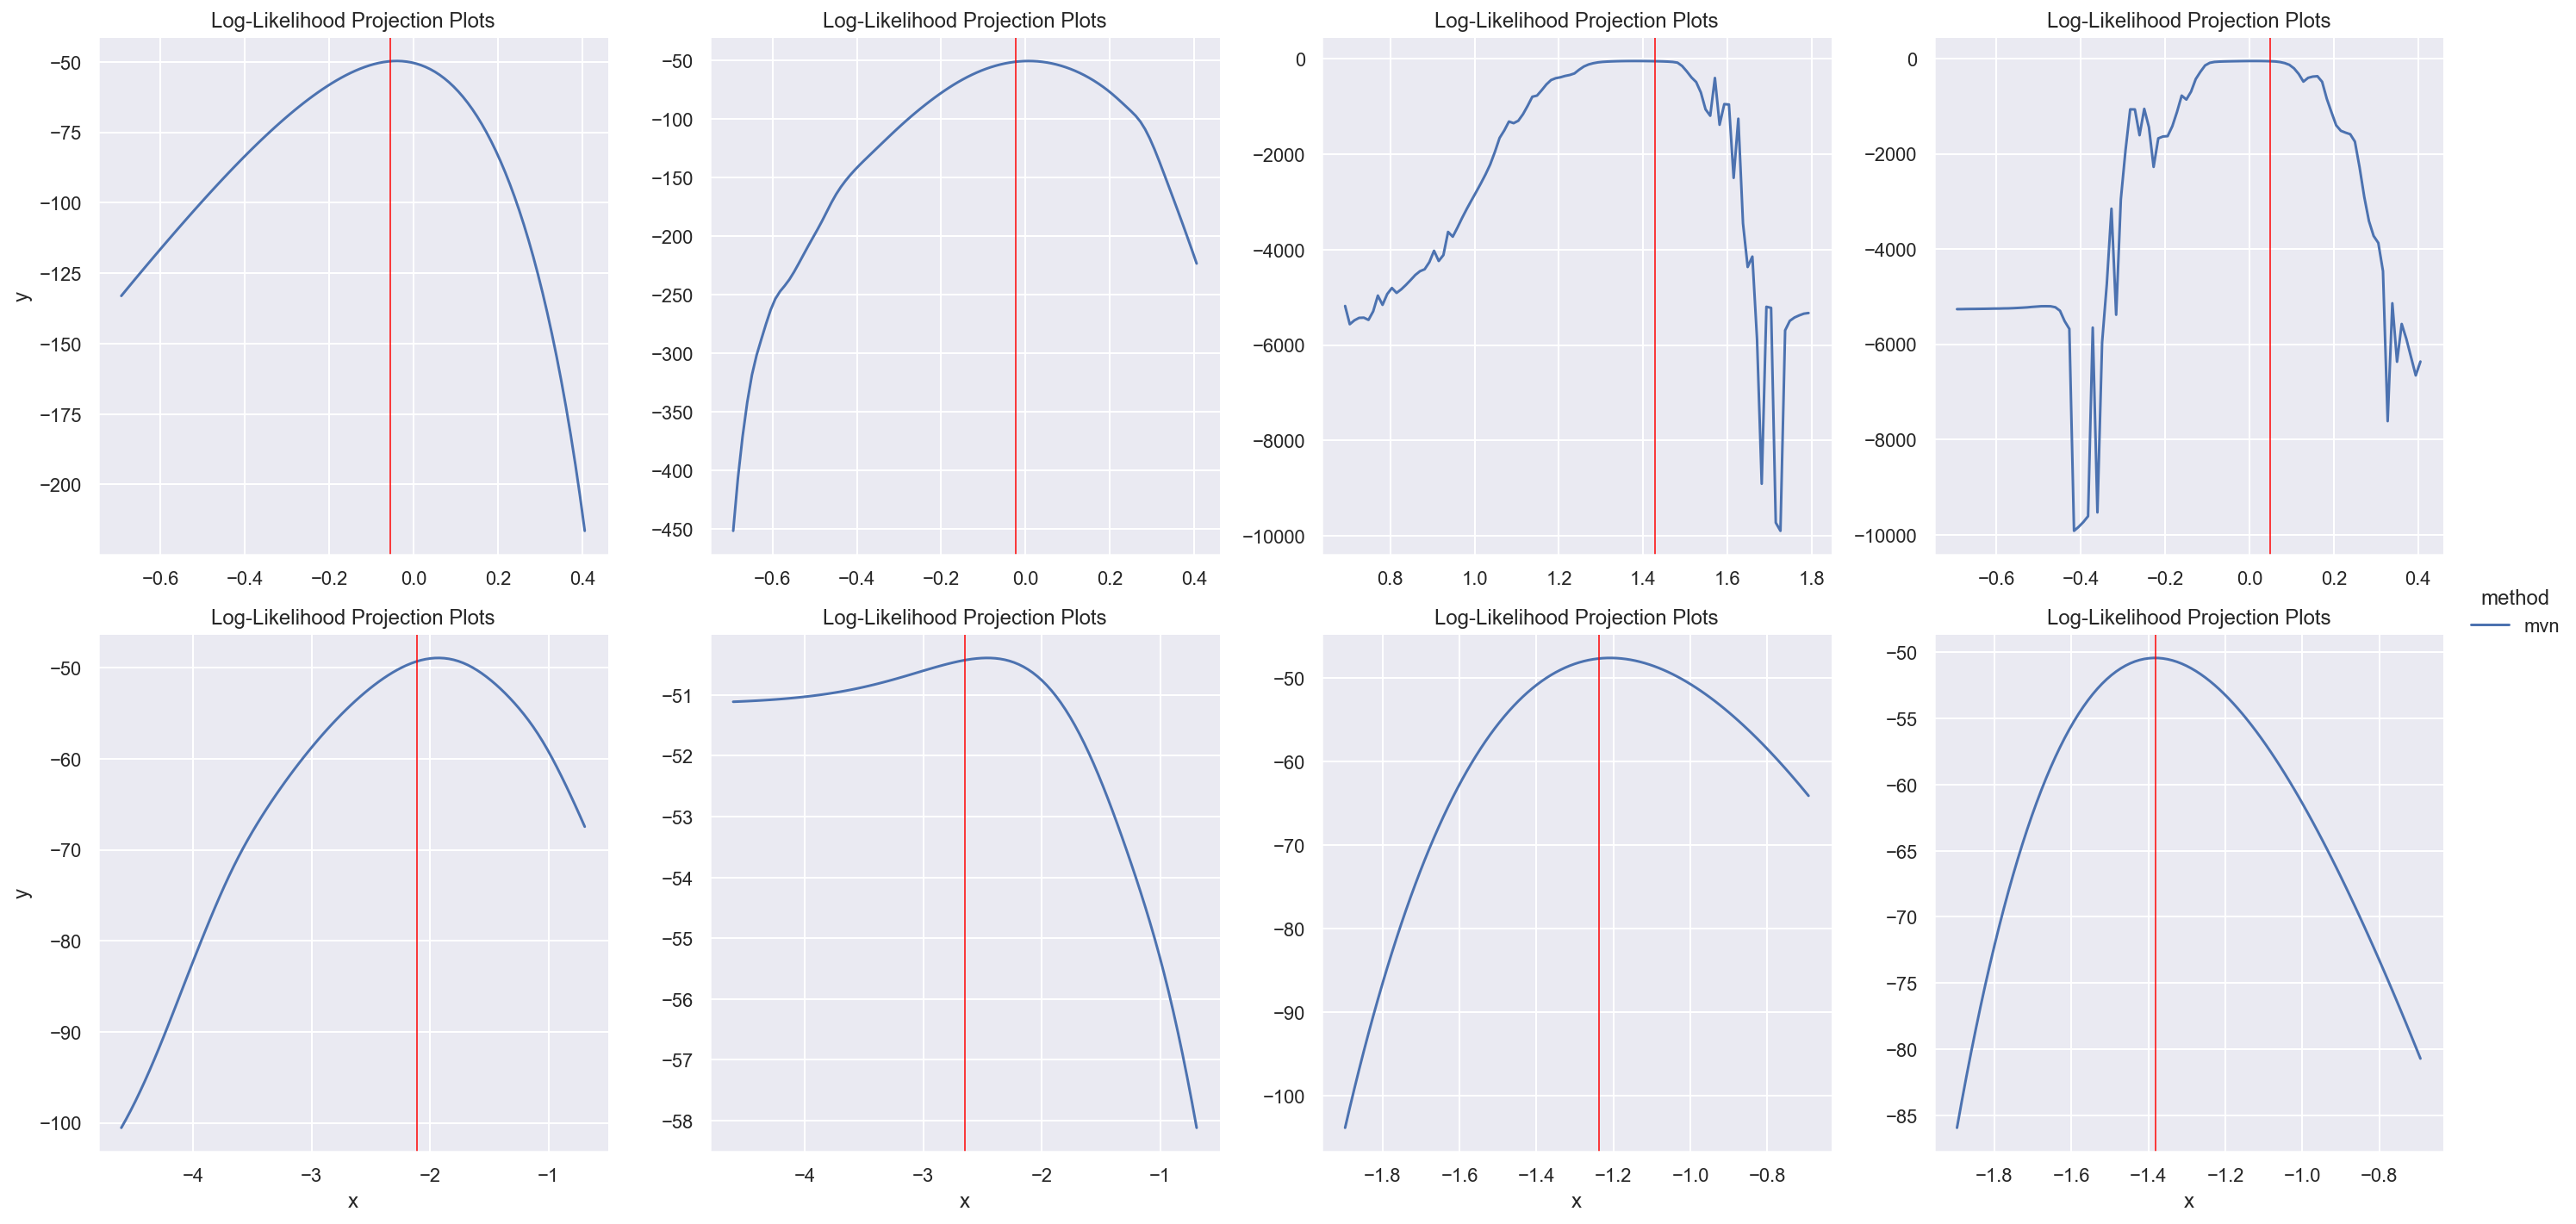

In [29]:
# Fix parameters and run both filters with these: 
n_particles = 250
n_iter = 500
learning_rate = 1e-3

mvn_params = simple_grad_descent(
    key = key,
    model = lotvol_model,
    grad_fun = pf.particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params))
)

print("Estimated params: ", mvn_params)

grid = sns.relplot(
    data=plot_mvn, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(mvn_params[ind], color='red', lw = 0.75);

In [30]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
hessian_fn = jax.jacfwd(jax.jacrev(pf.particle_neg_loglik_mvn))
hess = hessian_fn(
    mvn_params,
    key,
    n_particles=100,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

Is positive definite?:  True


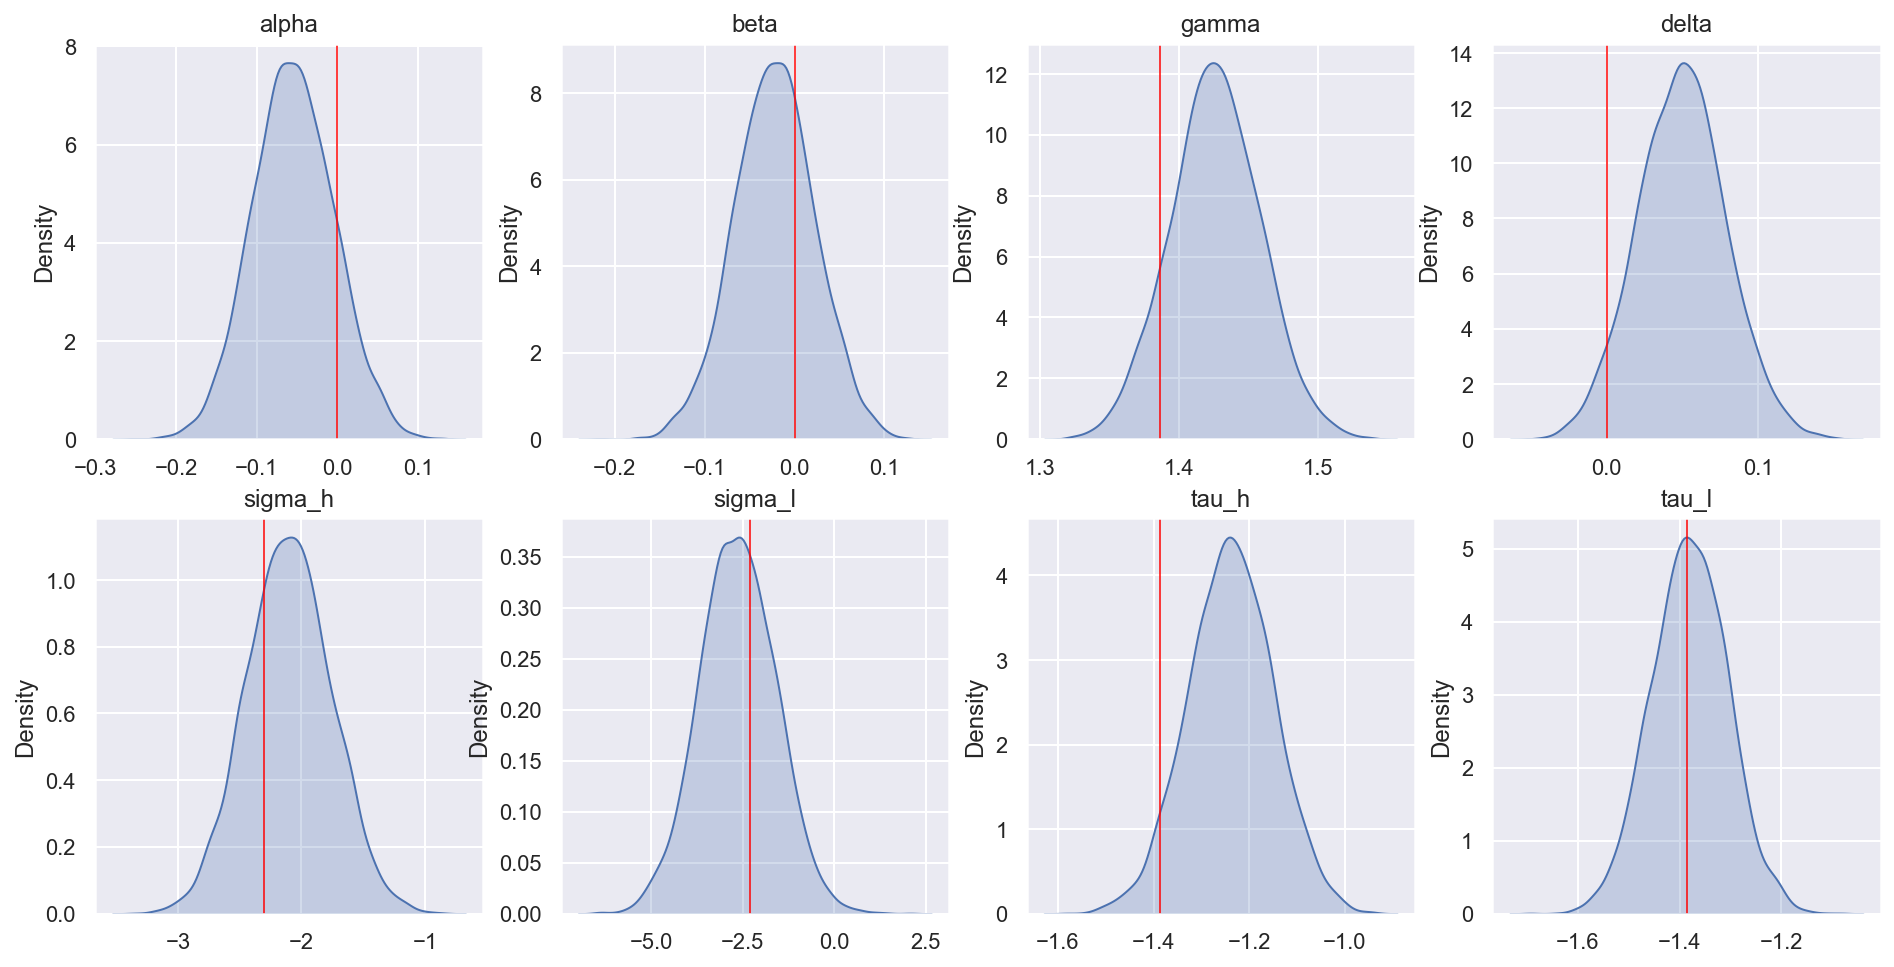

In [31]:
var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

# Particle Behavior

### Problem

When the parameters get far away from the true parameters, the MVN resampling method returns NaNs, which breaks down the entrie run of the particle filter. This section will investigate why that is the case. This is shown in the first plot below, which is a projection plot of 3 parameters. The MVN resampling method doesn't return an estimate of the log-likelihood for parameter values that are far from the true values

In particular I look at the entropy of the resampling distribution, which we ideally want to be high. 

---

### Answer

The $jk$-th entry of the weighted covariance matrix is of the form: 

$$ q_{jk} = \frac{1}{\sum_{i = 1}^N w_i^2} \sum_{i = 1}^N w_i(x_{ij} - \bar{x}_j)(x_{ik} - \bar{x}_k)$$

When all the weight goes to one particle, $\frac{1}{\sum_{i = 1}^N w_i^2} \to \inf$, and the resampling proceedure breaks down (produces NaN's for the remaining timepoints). This tends to happen when the current parameter value is far away from the true parameter value. 

This will not happen in multinomial resampling because even for extremely small weights, we continue to propagate the particles. 


### Solution

Add a small amount to the normalized probabilities, then re-normalize. This will prevent all the weight from accumulating on one particle without affecting the measurement model too much. We have to re-normalize to make sure $\sum_{i = 1}^N w_i^2 < 1$

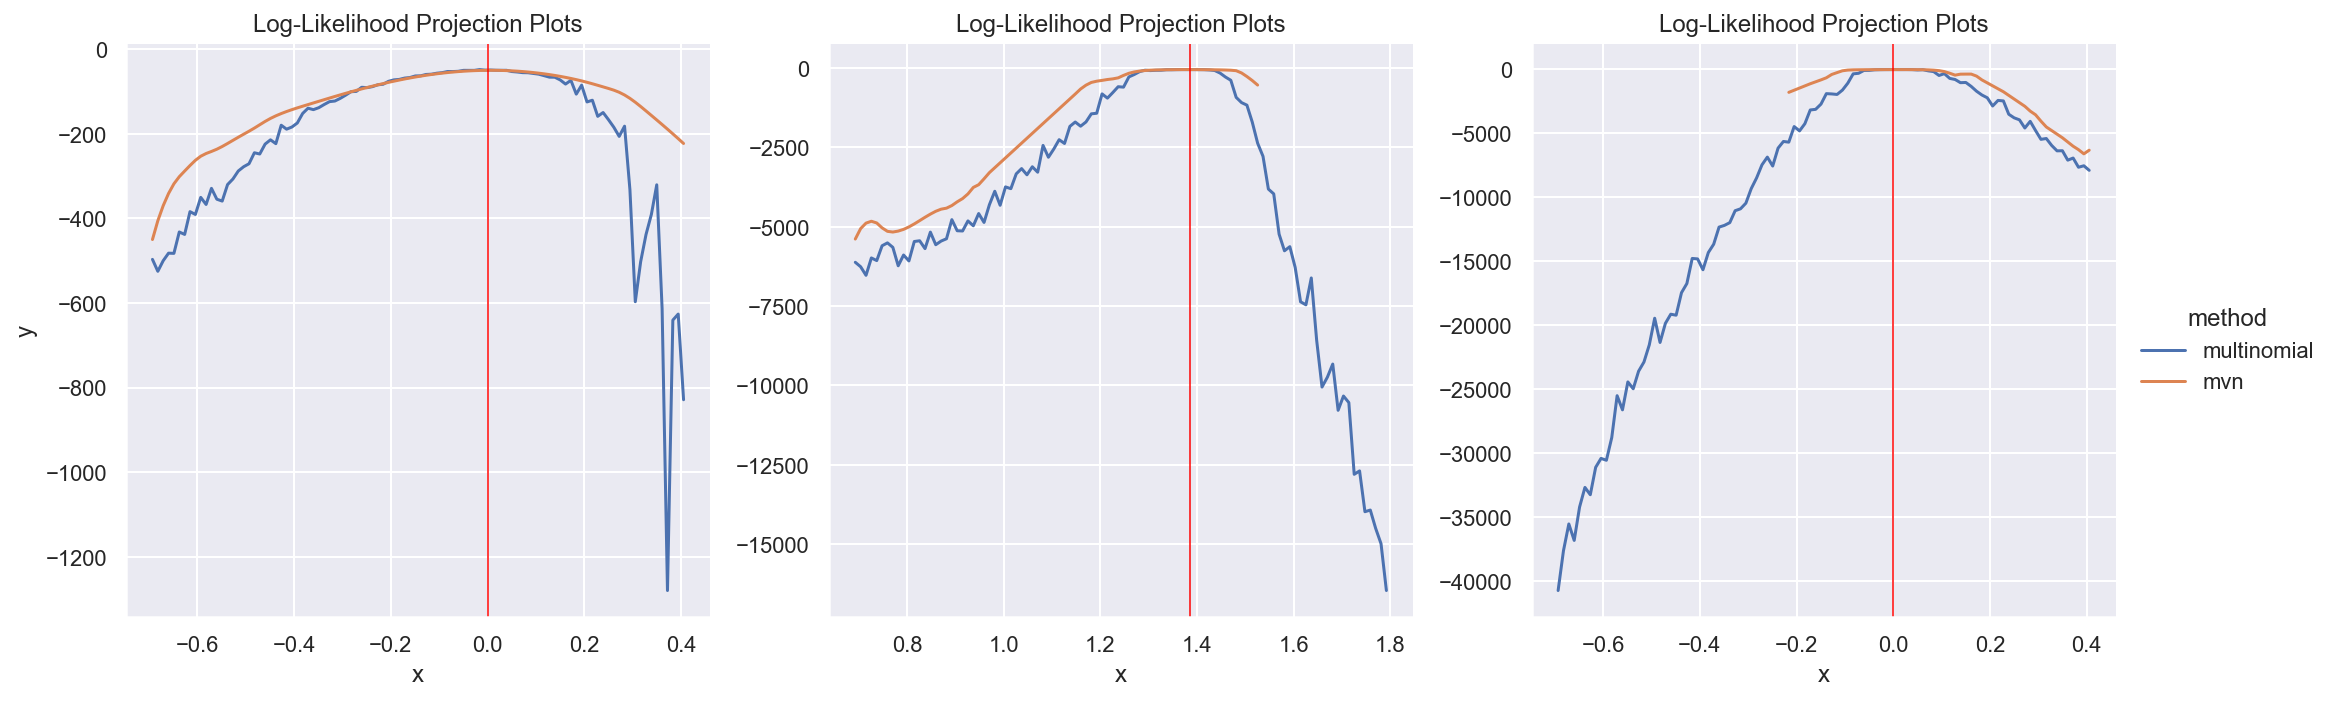

In [87]:
grid = sns.relplot(
    data=df[df.theta.isin(["beta", "gamma", "delta"])], 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=3,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind+1], color='red', lw = 0.75);

In [8]:
def entropy(data):
    data = pd.Series(data)
    p_data = data.value_counts()           # counts occurrence of each value
    entropy = scipy.stats.entropy(p_data)  # get entropy from counts
    return entropy

def _lweight_to_prob(logw):
    wgt = jnp.exp(logw - jnp.max(logw)) 
    prob = wgt / jnp.sum(wgt)
    return prob

In [14]:
n_part = 100
temp = pf.particle_filter(
    theta=jnp.log(jnp.array([.1  , .5  , 4.  , .5  , 0.1 , 0.1 , 0.25, 0.25])),
#     theta = theta,
    model=lotvol_model, 
    y_meas=y_meas, 
    n_particles=n_part, 
    key=key,
    particle_sampler = pf.particle_resample_mvn)

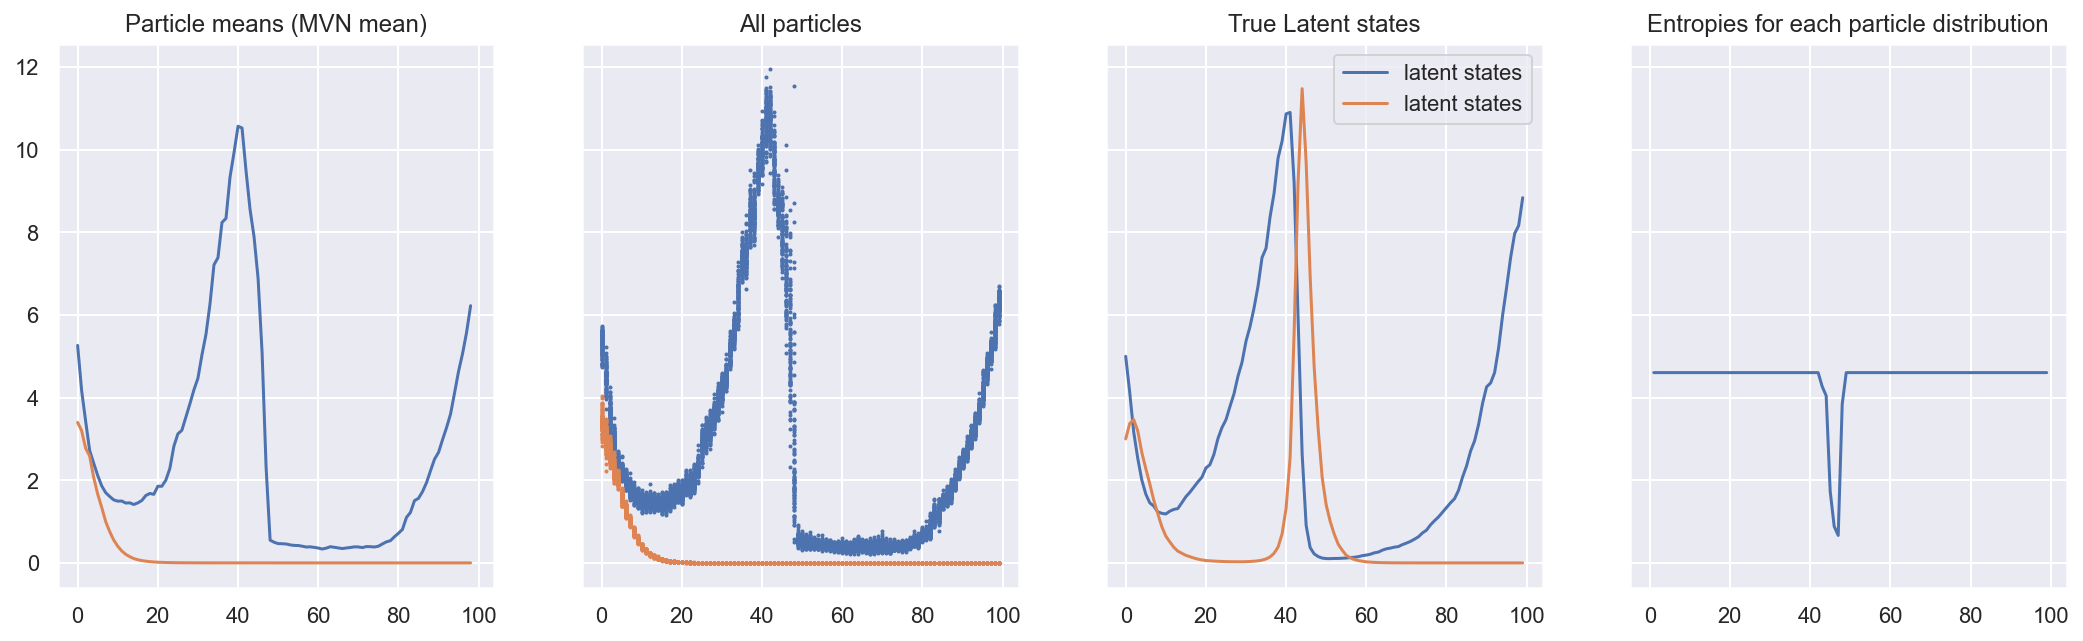

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 5), sharex = True, sharey=True)

ax[0].plot(jnp.exp(temp["x_particles_mu"].squeeze()))
ax[1].scatter(np.repeat(np.arange(0, n_obs), n_part), 
            jnp.exp(temp["x_particles"].squeeze()[:, :, 0].reshape(-1, 1)),
            s = 1)
ax[1].scatter(np.repeat(np.arange(0, n_obs), n_part), 
            jnp.exp(temp["x_particles"].squeeze()[:, :, 1].reshape(-1, 1)),
            s = 1);
ax[2].plot(jnp.exp(x_state.squeeze()), label = "latent states")

# calculate the entropy for each logw: 
entropies = list(map(lambda x: entropy((_lweight_to_prob(temp["logw"][x]))), np.arange(1, n_obs)))
sns.lineplot(np.arange(1, n_obs), 
             entropies,
             ax = ax[3]).set(title="Entropies for each particle distribution");

ax[0].set(title = "Particle means (MVN mean)")
ax[1].set(title = "All particles")
ax[2].set(title = "True Latent states")
ax[2].legend();

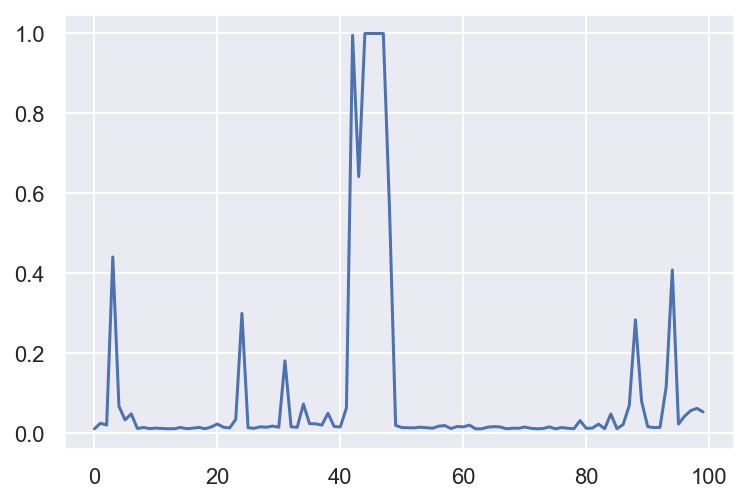

In [11]:
# sum(w^2)
plt.plot(list(map(lambda ii: sum(_lweight_to_prob(temp["logw"][ii])**2), np.arange(0, n_obs))));

## Multinomial Resampling Behavior

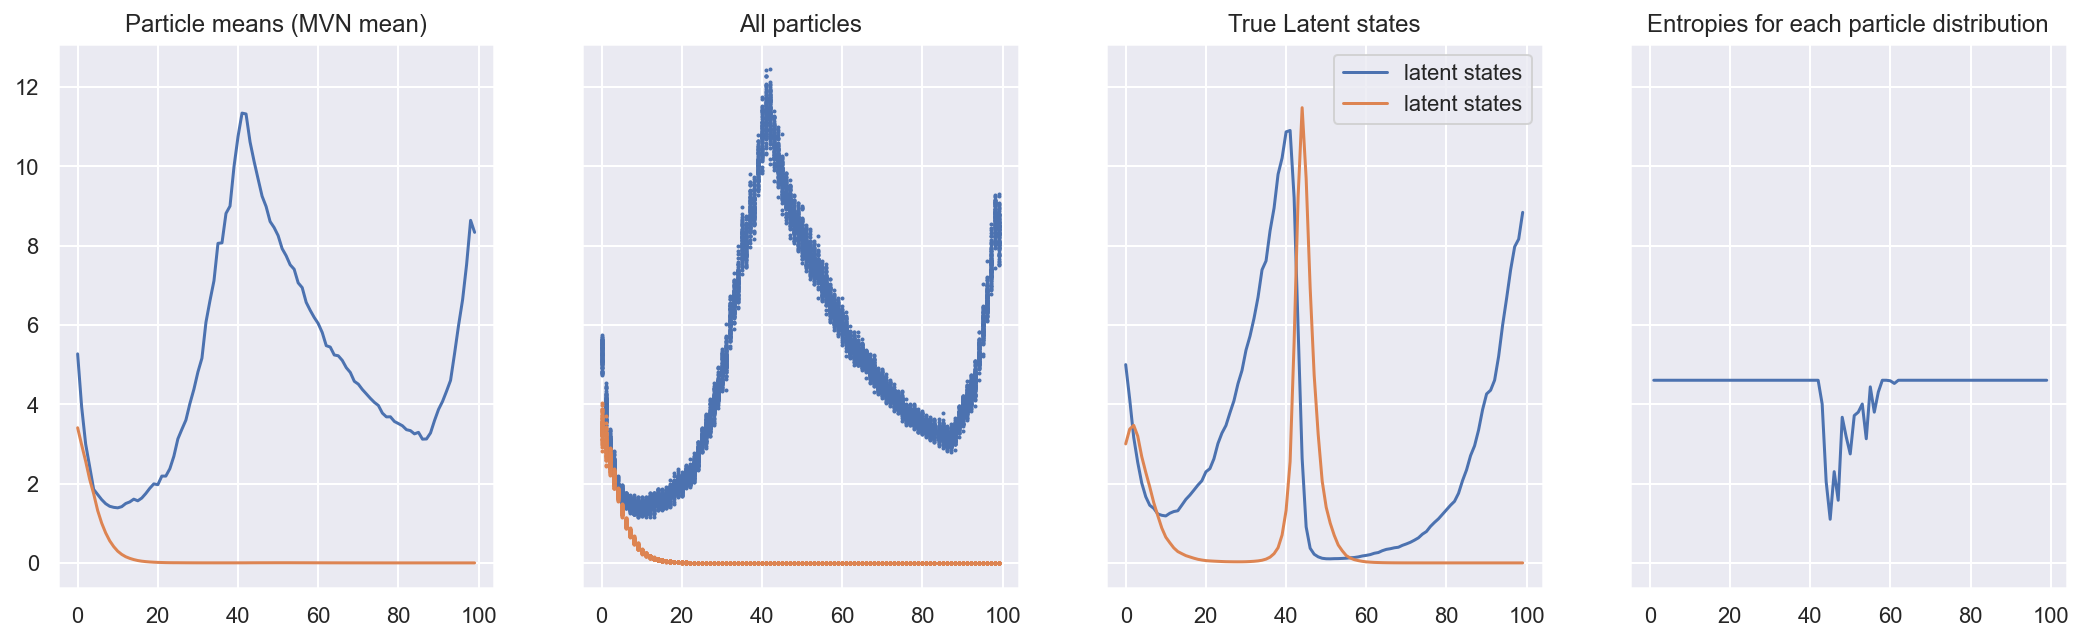

In [16]:
n_part = 100
temp2 = pf.particle_filter(
    theta=jnp.log(jnp.array([.5  , 1.  , 4.  , .5  , 0.1 , 0.1 , 0.25, 0.25])),
#     theta = jnp.log(theta),
    model=lotvol_model, 
    y_meas=y_meas, 
    n_particles=n_part, 
    key=key)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 5), sharex = True, sharey=True)

ax[0].plot(jnp.mean(jnp.exp(temp2["x_particles"].squeeze()), axis = 1))
ax[1].scatter(np.repeat(np.arange(0, n_obs), n_part), 
            jnp.exp(temp2["x_particles"].squeeze()[:, :, 0].reshape(-1, 1)),
            s = 1)
ax[1].scatter(np.repeat(np.arange(0, n_obs), n_part), 
            jnp.exp(temp2["x_particles"].squeeze()[:, :, 1].reshape(-1, 1)),
            s = 1);
ax[2].plot(jnp.exp(x_state.squeeze()), label = "latent states")
entropies = list(map(lambda x: entropy((_lweight_to_prob(temp2["logw"][x]))), np.arange(1, n_obs)))
sns.lineplot(np.arange(1, n_obs), 
             entropies,
             ax = ax[3]).set(title="Entropies for each particle distribution");

ax[0].set(title = "Particle means (MVN mean)")
ax[1].set(title = "All particles")
ax[2].set(title = "True Latent states")
ax[2].legend();

# Comparison with Multinomial Resampling

In this section, we make comparisons between the bootstrap particle filter with stochastic optimization and the MVN particle filter using deterministic optimization. In particular, we are interested in the accuracy and stability (variance) of the estimate. We are also interested in the number of particles needed to produce consistent estimates. 

Estimated params:  [-0.1735427  -0.272741    1.3848094  -0.04979946 -2.3517346  -2.2874007
 -1.3362861  -1.3776929 ]


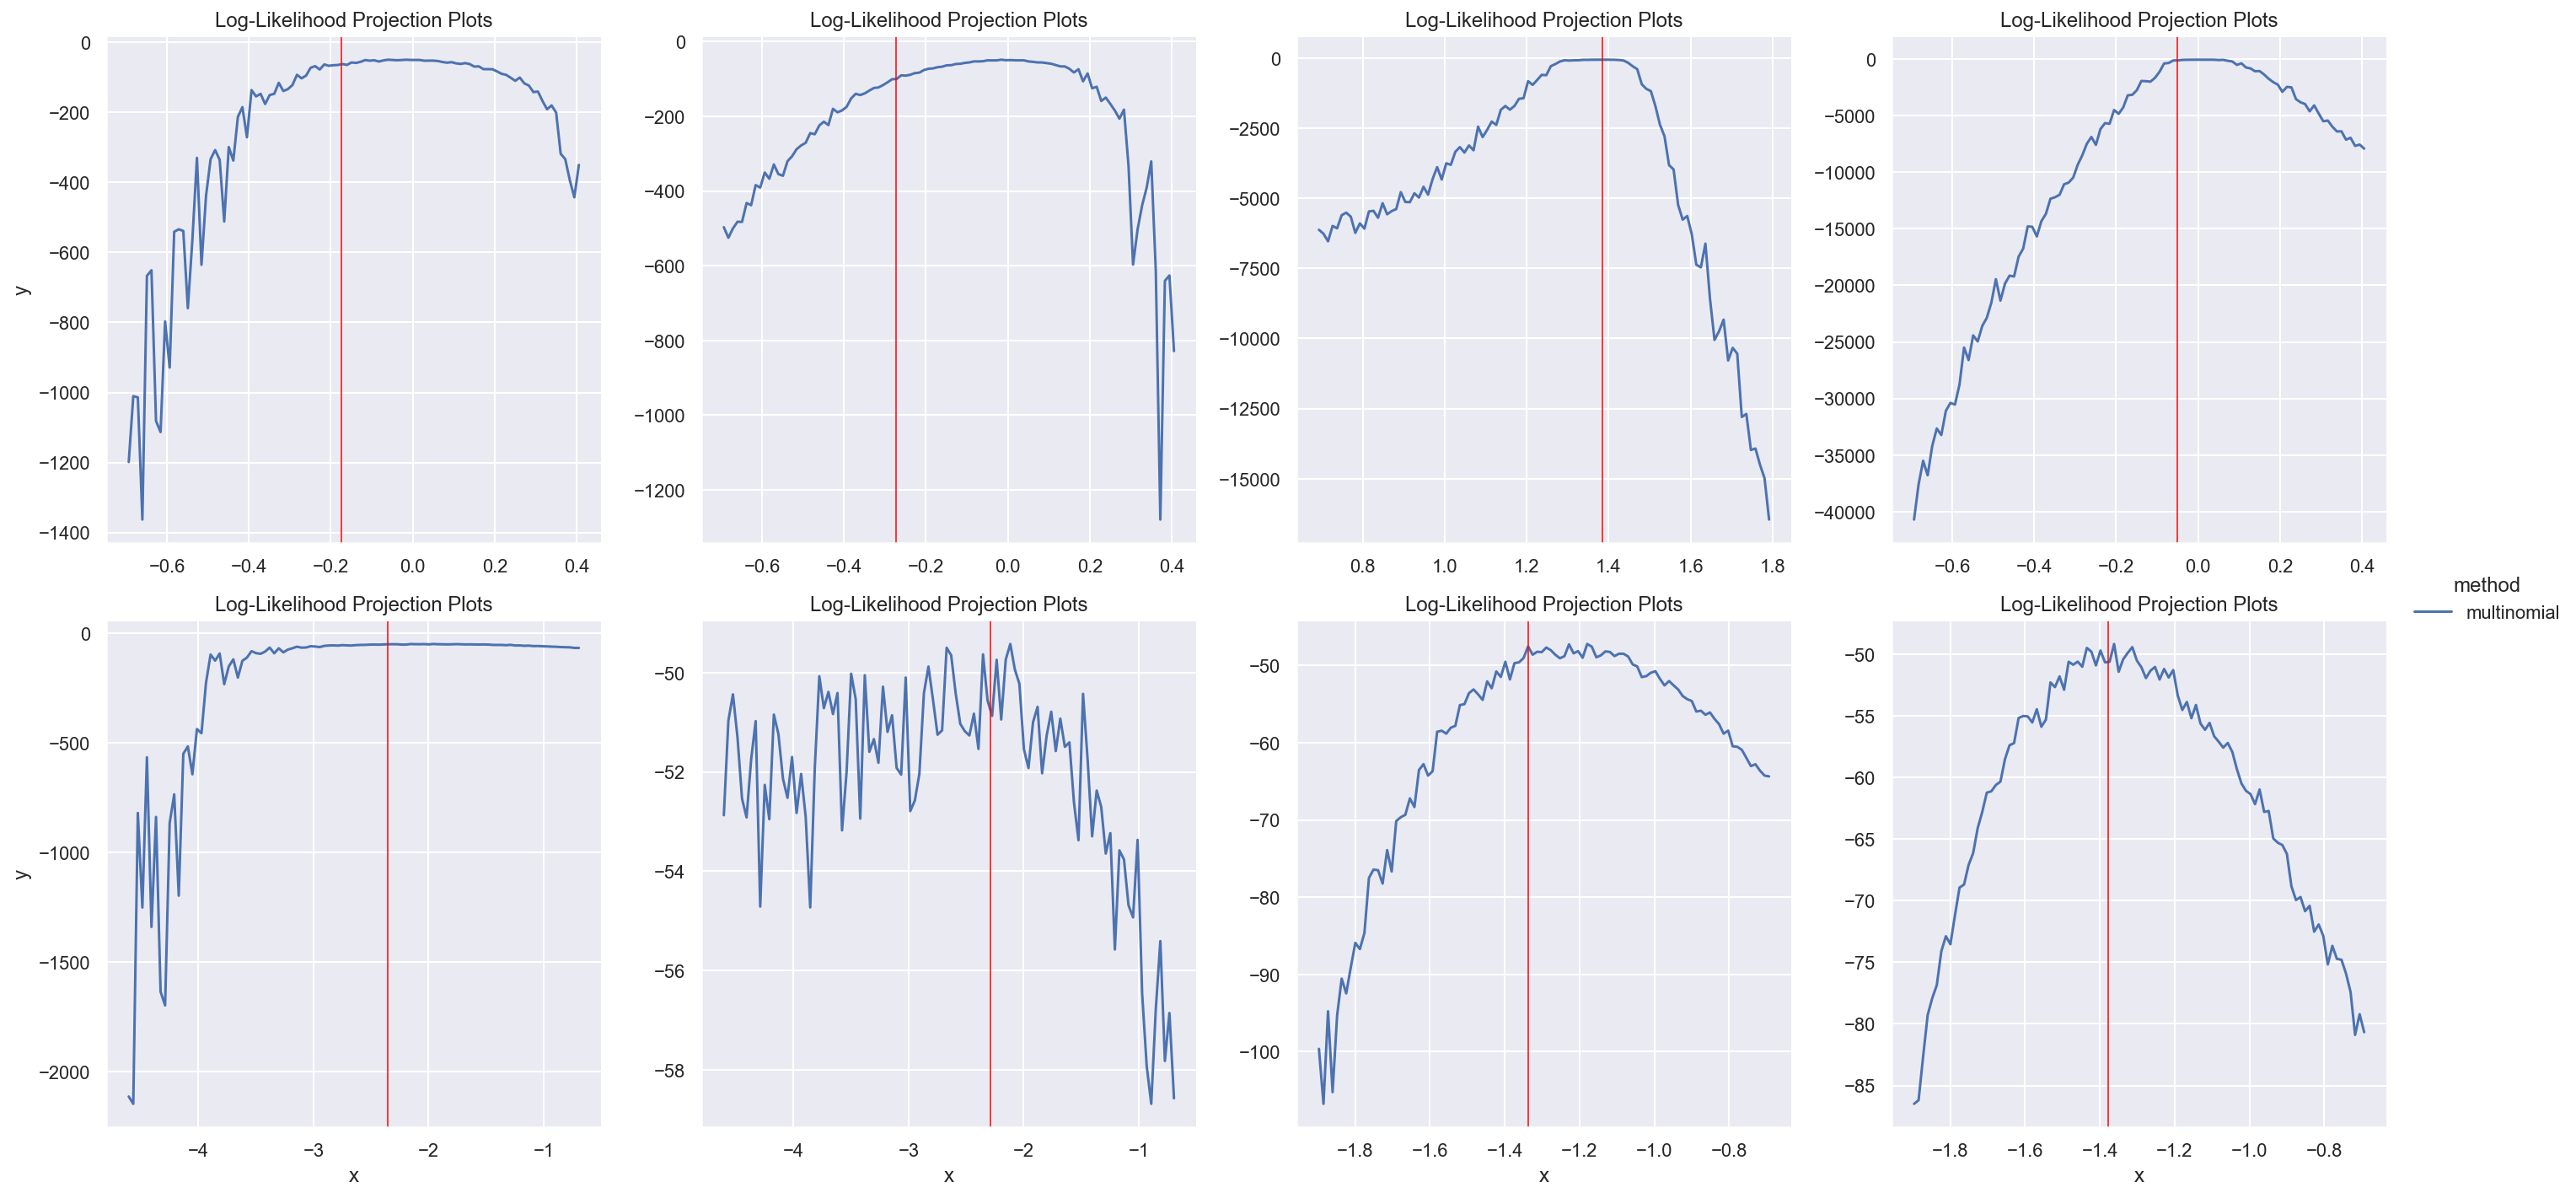

In [32]:
# Fix parameters and run both filters with these: 
n_particles = 250
n_iter = 500
learning_rate = 1e-4

multinom_params = stoch_opt(
    key = key,
    model = lotvol_model,
    grad_fun = pf.particle_neg_loglik,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params))
)

print("Estimated params: ", multinom_params)

grid = sns.relplot(
    data=plot_multinom, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots");

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(multinom_params[ind], color='red', lw = 0.75);

In [33]:
print("MVN resampling MSE: {}".format(sum((mvn_params - theta)**2)))
print("Multinomial resampling MSE: {}".format(sum((multinom_params - theta)**2)))

MVN resampling MSE: 0.1862332292184874
Multinomial resampling MSE: 0.11220796038674052


### Variance Estimates

In [34]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
multinom_hessian_fn = jax.jacfwd(jax.jacrev(pf.particle_neg_loglik))
multinom_hess = multinom_hessian_fn(
    multinom_params,
    key,
    n_particles=n_particles,
    y_meas=y_meas,
    model=lotvol_model)
print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(multinom_hess) >= 0))

Is positive definite?:  True


### Variance Estimates

Once the hessian is positive definite, we can find the posterior variance, otherwise continue optimization because we are not at a mode. Posterior variance is the inverse negative hessian of the log-likelihood (Fisher Information)

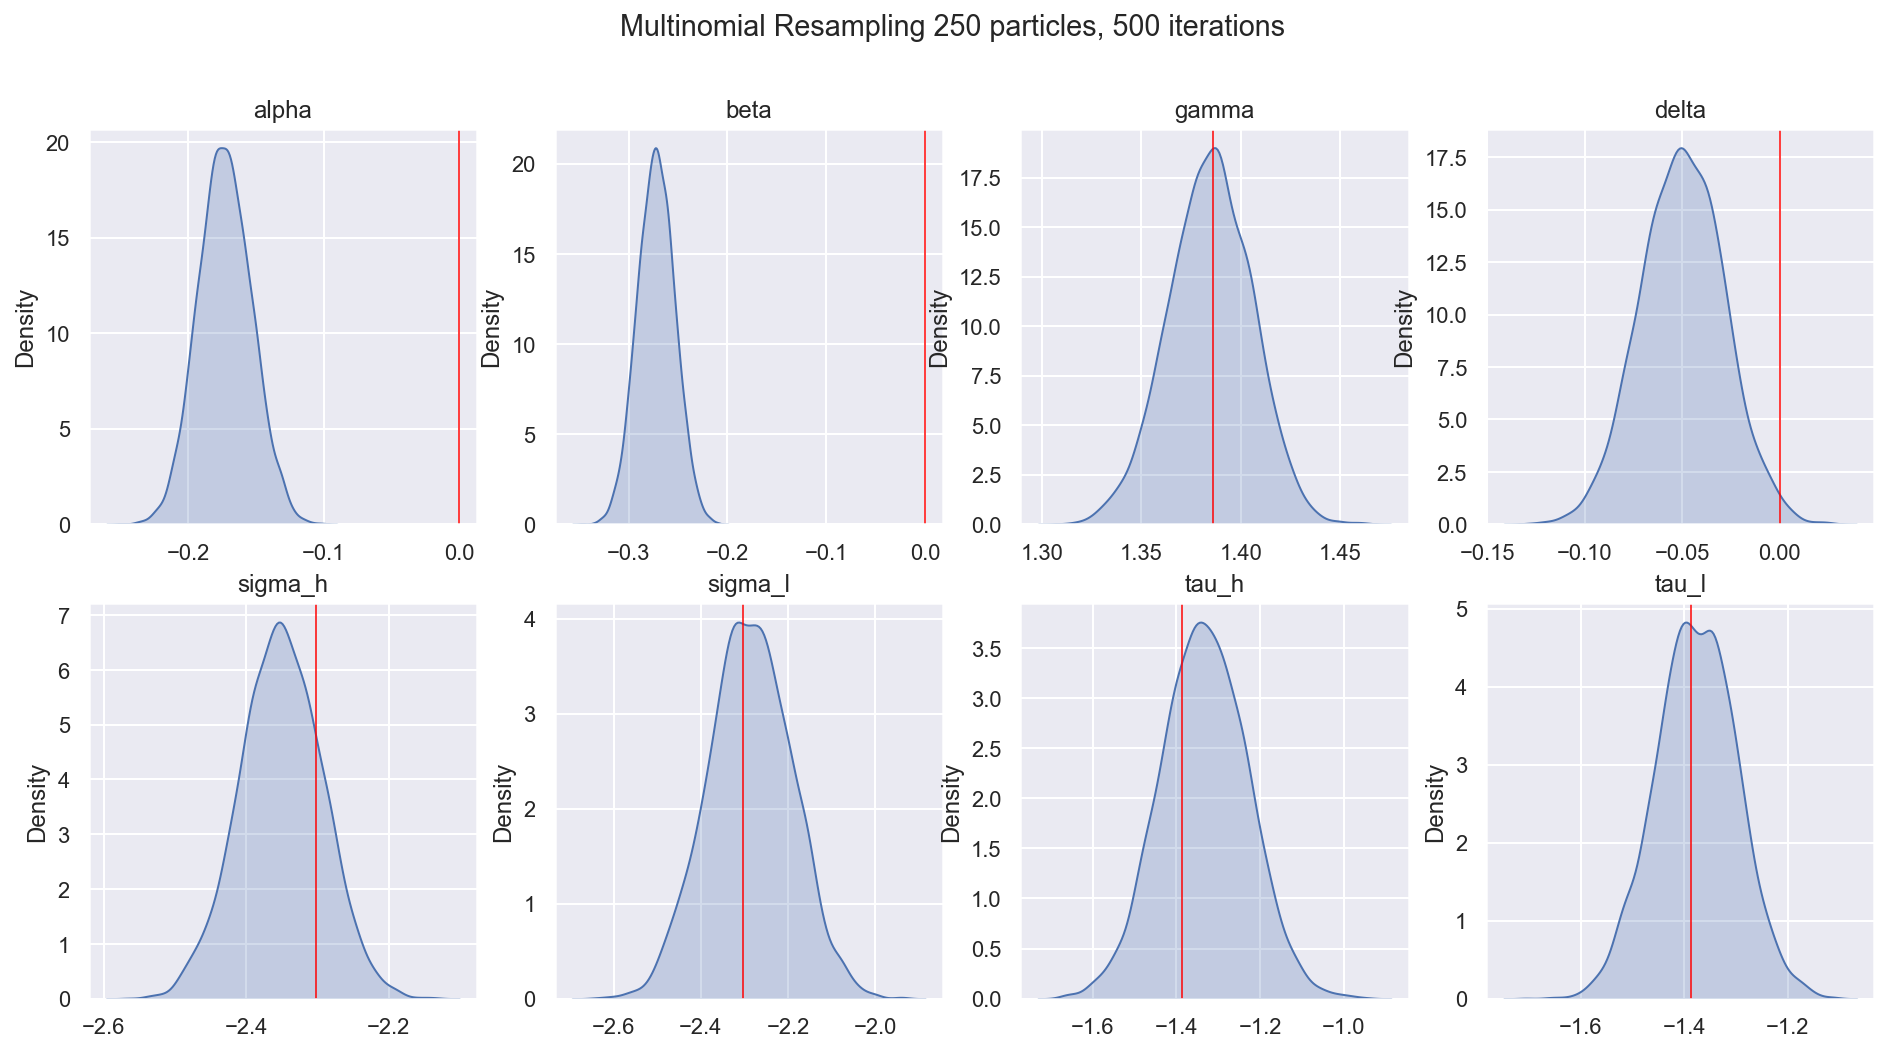

In [37]:
multinom_var = jnp.linalg.inv(multinom_hess) #+ np.diag([1e-3]*len(multinom_params))
mn_mle_samples = random.multivariate_normal(
    key=key, 
    mean=multinom_params, 
    cov=multinom_var, 
    shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Multinomial Resampling {} particles, {} iterations".format(n_particles, n_iter)) 
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mn_mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

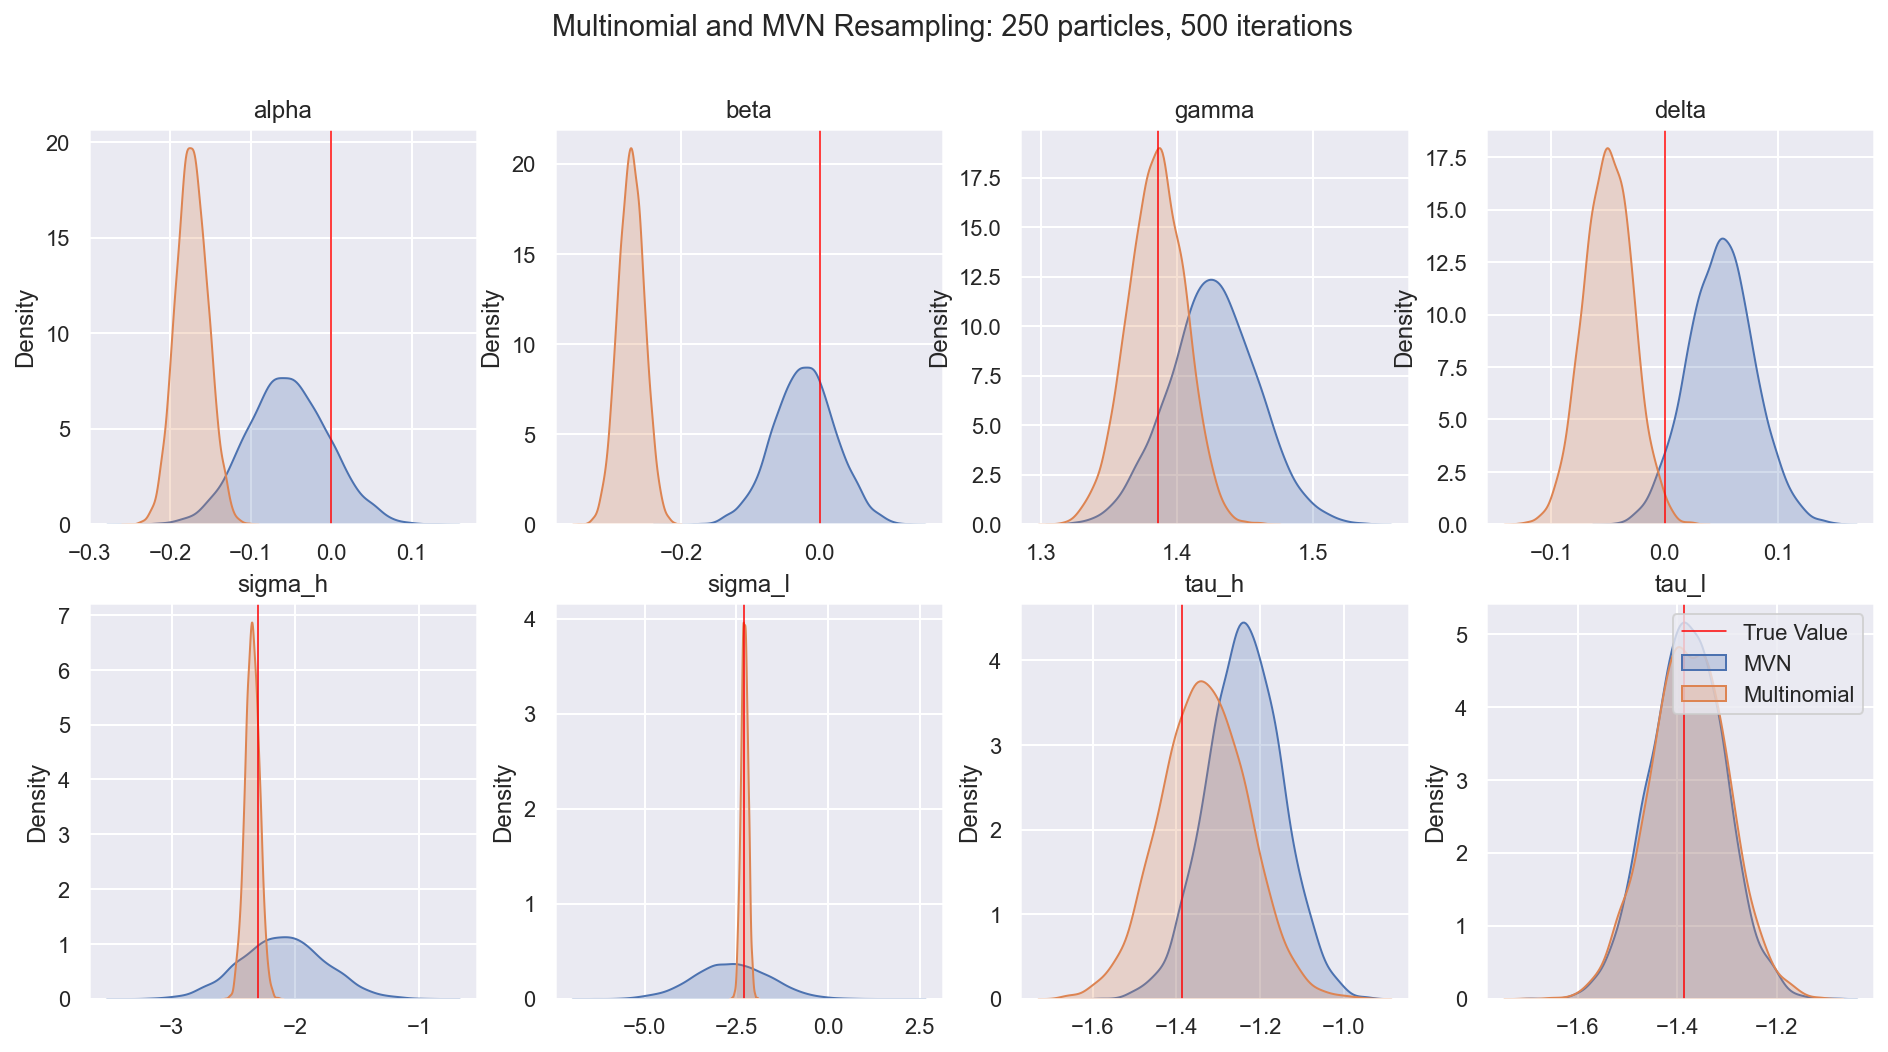

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Multinomial and MVN Resampling: {} particles, {} iterations".format(n_particles, n_iter)) 
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, 
                label = "MVN",
                shade = True).set_title(theta_names[ind])
    sns.kdeplot(mn_mle_samples[:, ind], ax = _ax, 
                label = "Multinomial",
                shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75, label = "True Value")
    
plt.legend()
plt.show();

## TODO

- Convert LotVol SDE to log scale. Use Mohan's branch - In progress
- How do the resampling methods for different resolution numbers?
- Create notebook of comparison for MVN VS Multinomial resampling methods. Assume research group only understand the two filters but don't know about the differences.
- Use Kanika's library for proj plots